# Table of Contents
 <p><div class="lev1"><a href="#Task-1.-Compiling-Ebola-Data"><span class="toc-item-num">Task 1.&nbsp;&nbsp;</span>Compiling Ebola Data</a></div>
 <div class="lev1"><a href="#Task-2.-RNA-Sequences"><span class="toc-item-num">Task 2.&nbsp;&nbsp;</span>RNA Sequences</a></div>
 <div class="lev1"><a href="#Task-3.-Class-War-in-Titanic"><span class="toc-item-num">Task 3.&nbsp;&nbsp;</span>Class War in Titanic</a></div></p>

In [1]:
DATA_FOLDER = './Data'
import pandas as pd
import numpy as np
import os, glob
from typing import Generator

## Task 1. Compiling Ebola Data

The `DATA_FOLDER/ebola` folder contains summarized reports of Ebola cases from three countries (Guinea, Liberia and Sierra Leone) during the recent outbreak of the disease in West Africa. For each country, there are daily reports that contain various information about the outbreak in several cities in each country.

Use pandas to import these data files into a single `Dataframe`.
Using this `DataFrame`, calculate for *each country*, the *daily average per month* of *new cases* and *deaths*.
Make sure you handle all the different expressions for *new cases* and *deaths* that are used in the reports.

In [2]:
#Initialize file paths for each country
def get_file_paths(root: str) -> Generator[str, None, None]:
    """
    Returns the paths for all the files in the subtree of `root`
    """
    for (dir_path, _, file_names) in os.walk(root):
        yield from [os.path.join(dir_path, file_name) for file_name in file_names]

gn_file_paths = [*get_file_paths("./data/guinea_data")]
lr_file_paths = [*get_file_paths("./data/liberia_data")]
sl_file_paths = [*get_file_paths("./data/sl_data")]

In [3]:
def normalize_daily_data(raw_frame: pd.core.frame.DataFrame, variable_col):
    """
    Normalize the dataframe obtained by reading a a daily CSV to have
    one row per (region/date) pair and use columns for each variable.
    """
    # Normalize column names
    raw_frame.columns = map(str.lower, raw_frame.columns)
    
    DATE: str = "date"
    VARIABLE: str = variable_col
    REGION: str = "region"
    VALUE: str = "value"
    
    values_stack = []
    var_names = [] # Index of variables

    # Iterate over each variable (row)
    for index, row in raw_frame.iterrows():
        date = row[DATE]
        var_name = row[VARIABLE]
        if var_name in var_names:
            # Ignore variable: it was already defined
            continue
        var_names.append(var_name)
        
        # Iterate over each region (column)
        for col_name, value in row.iteritems():
            if col_name in {DATE, VARIABLE, "western area combined", "national", "totals"}:
                # Ignore: not a region
                continue
            values_stack.append({DATE: pd.to_datetime(date), REGION: col_name, VARIABLE: var_name, VALUE: value})
            
    stack_frame = pd.DataFrame(values_stack)
    pivoted = stack_frame.set_index([DATE, REGION, VARIABLE]).unstack(VARIABLE)
    # Drop to level ("value") of the column's multi index
    pivoted.columns = [col[1] for col in pivoted.columns] 
    return pivoted


## Compute merged dataframes for each country

In [4]:
def normalize_sl(raw_frame: pd.core.frame.DataFrame):
    """
    Normalize the dataframe obtained by reading a Sierra Leone CSV to have
    one row per (region/date) pair and use columns for each variable.
    """
    return normalize_daily_data(raw_frame, "variable")

sl = pd.concat([normalize_sl(pd.read_csv(path)) for path in sl_file_paths])

ValueError: No objects to concatenate

In [5]:
def normalize_lr(raw_frame: pd.core.frame.DataFrame):
    """
    Normalize the dataframe obtained by reading a Liberia CSV to have
    one row per (region/date) pair and use columns for each variable.
    """
    return normalize_daily_data(raw_frame, "variable")

lr = pd.concat([normalize_lr(pd.read_csv(path)) for path in lr_file_paths])

ValueError: No objects to concatenate

In [ ]:
def normalize_gn(raw_frame: pd.core.frame.DataFrame):
    """
    Normalize the dataframe obtained by reading a Guinea CSV to have
    one row per (region/date) pair and use columns for each variable.
    """
    return normalize_daily_data(raw_frame, "description")

gn = pd.concat([normalize_gn(pd.read_csv(path)) for path in gn_file_paths])

In [ ]:
# Ensure that the column names are lowercase
for df in [gn, sl, lr]:
    df.columns = map(str.lower, df.columns)

In [ ]:
# Ensure that the percentages are expressed as floats

import math

def percent_to_float(str_or_nan):
    val = str_or_nan
    if type(str_or_nan) == str:
        str_or_nan = str_or_nan.replace("%", "")
        try:
            val = float(str_or_nan)
        except ValueError:
            val = float('nan')
    return val / 100

gn["fatality rate for confirmed and probables"] = gn["fatality rate for confirmed and probables"].map(percent_to_float)
sl["percent_seen"] = sl["percent_seen"].map(percent_to_float)

## Create columns for deaths and new cases analysis

For the Liberia and Sierra Leone, we select already available that are mostly complete.
We select the confirmed cases and deaths to reduce the uncertainty of the data.
For the Guinea, the daily data is too sparse (missing in too many regions/days) so we work with the delta on cumulated values instead.

In [43]:
# Copy columns to normalize the name
lr["$deaths"] = pd.to_numeric(lr["newly reported deaths"])
lr["$new_cases"] = pd.to_numeric(lr["new case/s (confirmed)"])
# See next cell for Guinea
# gn["$deaths"] = pd.to_numeric(gn["total deaths of confirmed"])
# gn["$new_cases"] = pd.to_numeric(gn["total cases of confirmed"])
sl["$deaths"] = pd.to_numeric(sl["death_confirmed"])
sl["$new_cases"] = pd.to_numeric(sl["new_confirmed"])

NameError: name 'lr' is not defined

In [44]:
# Use delta of cumulated values for Guinea
# We split the dataframe per region, compute the deltas and then merge the results.

regional_data_frames = []

gn["total deaths of confirmed"] = pd.to_numeric(gn["total deaths of confirmed"])
gn["total cases of confirmed"] = pd.to_numeric(gn["total cases of confirmed"])
tmp_gn = gn[[*gn.columns]]
tmp_gn.reset_index(inplace=True)
tmp_gn = tmp_gn.set_index(["region", "date"])
tmp_gn.sort_index(inplace=True)
# tmp_gn is now sorted and indexed by region and date

for region in tmp_gn.index.levels[0]:
    regional_df = tmp_gn.loc[region, :].copy()
    # Compute $deaths and $new_cases as the rate of change of "total deaths of confirmed" and "total cases of confirmed"
    # After the diff, replace the first NaN by the original value (assume that the total is zero at `time == -Inf`)
    regional_df["$deaths"] = regional_df["total deaths of confirmed"].fillna(method="pad").diff().clip(0).fillna(regional_df["total deaths of confirmed"])
    regional_df["$new_cases"] = regional_df["total cases of confirmed"].fillna(method="pad").diff().clip(0).fillna(regional_df["total cases of confirmed"])
    regional_df["region"] = region
    regional_data_frames.append(regional_df)

regional_data_frames[0]

gn = pd.concat(regional_data_frames)
gn.reset_index(inplace=True)
#     gn.drop("index")
gn = gn.set_index(["date", "region"])
gn.sort_index(inplace=True)

NameError: name 'gn' is not defined

In [ ]:
# Emit merged data frames to the disk (to better view them)

COUNTRY = "country"
REGION: str = "region"
DATE: str = "date"

# gn.rename(columns={'cumulative cfr': 'cfr'}, inplace=True)

gn.to_csv("./gn.csv")
sl.to_csv("./sl.csv")
lr.to_csv("./lr.csv")

# Anotate the country
gn[COUNTRY] = "gn"
sl[COUNTRY] = "sl"
lr[COUNTRY] = "lr"

# Concat all and reindex by country/region/date
ebola = pd.concat([gn, lr, sl])
ebola.reset_index(inplace=True)
ebola = ebola.set_index([COUNTRY, DATE, REGION])
ebola.to_csv("./ebola.csv")

### Daily average per month of new cases and deaths

In [ ]:
def duration_to_days(x):
    return x 

def get_monthly_new_cases_and_deaths(df):
    # Keep only the 2 columns we need
    data = df.reset_index(level=1)[["$deaths", "$new_cases"]]
    # Sum over all the regions for each date
    all_regions = data.dropna().groupby("date").sum()
    # Compute "days since last data-point" (to deal with mi)
    all_regions["days"] = all_regions.index
    all_regions["days"] = all_regions["days"].diff() / pd.Timedelta(1, unit='d')
    all_regions["$premultiplied_daily_deaths"] = all_regions["$deaths"] / all_regions["days"]
    all_regions["$premultiplied_daily_new_cases"] = all_regions["$new_cases"] / all_regions["days"]

    result = all_regions.groupby([all_regions.index.year, all_regions.index.month]).sum()
    # Remove temporary columns
    result = result.drop("$deaths", axis=1).drop("$new_cases", axis=1).drop("days", axis=1)
    result.rename(columns={"$premultiplied_daily_deaths": "Daily deaths"}, inplace=True)
    result.rename(columns={"$premultiplied_daily_new_cases": "Daily new cases"}, inplace=True)
    return result

## Guinea

In [45]:
get_monthly_new_cases_and_deaths(gn)

NameError: name 'get_monthly_new_cases_and_deaths' is not defined

## Liberia

In [46]:
get_monthly_new_cases_and_deaths(lr)

NameError: name 'get_monthly_new_cases_and_deaths' is not defined

## Sierra Leone

In [ ]:
get_monthly_new_cases_and_deaths(sl)

## Task 2. RNA Sequences

In the `DATA_FOLDER/microbiome` subdirectory, there are 9 spreadsheets of microbiome data that was acquired from high-throughput RNA sequencing procedures, along with a 10<sup>th</sup> file that describes the content of each. 

Use pandas to import the first 9 spreadsheets into a single `DataFrame`.
Then, add the metadata information from the 10<sup>th</sup> spreadsheet as columns in the combined `DataFrame`.
Make sure that the final `DataFrame` has a unique index and all the `NaN` values have been replaced by the tag `unknown`.

### Our approach
We have to chosen to set the taxon as the primary index because we believe it is the most meaningful data in the set. 
However, the index is formed by the taxon, the sample, the group and the barcode. Here the index would also have been unique without the BarCode, however it is more general. 
To process the data, we match the BarCode with the name file without its extension, as it seems to be the only way to assciate the others metadata with it. 
With the actual processing, we can scale our treatment for more files, as it loop over the list of files in the data folder.

In [13]:
#First we get all the filenames and create a list with only Barcodes from each file  
filePaths = glob.glob(os.path.join(DATA_FOLDER,"microbiome","MID*.xls"))
fileBarCode = [os.path.basename(x).replace('.xls','') for x in filePaths]
#We load the metadata in a dataFrame to have an easy access
metaFrame = pd.read_excel(os.path.join(DATA_FOLDER,"microbiome","metadata.xls"))
metaFrame = metaFrame.set_index(['BARCODE'])
concatframe = pd.DataFrame()
tempList =[]
#We load each file into a dataFrame and add it the data assiocated to its barcode
for p in range(len(filePaths)):
    df =pd.read_excel(filePaths[p],names = ['Taxon', 'Value'],header=None).assign(BarCode=fileBarCode[p]).assign(Group=metaFrame.get_value(fileBarCode[p], "GROUP")).assign(Sample=metaFrame.get_value(fileBarCode[p], "SAMPLE"))
    tempList.append(df)
#We then concatenate everything, replace NA by unknown and add in index
concatframe = pd.concat(tempList)
concatframe.fillna(value='unknown',inplace=True)
concatframe.set_index(['Taxon','Sample','Group','BarCode'],inplace=True)
concatframe=concatframe.sort_index(level=['Taxon','Sample','Group','BarCode'])
concatframe


ModuleNotFoundError: No module named 'xlrd'

## Task 3. Class War in Titanic

Use pandas to import the data file `Data/titanic.xls`. It contains data on all the passengers that travelled on the Titanic.

In [ ]:
from IPython.core.display import HTML
HTML(filename=DATA_FOLDER+'/titanic.html')

For each of the following questions state clearly your assumptions and discuss your findings:
1. Describe the *type* and the *value range* of each attribute. Indicate and transform the attributes that can be `Categorical`. 
2. Plot histograms for the *travel class*, *embarkation port*, *sex* and *age* attributes. For the latter one, use *discrete decade intervals*. 
3. Calculate the proportion of passengers by *cabin floor*. Present your results in a *pie chart*.
4. For each *travel class*, calculate the proportion of the passengers that survived. Present your results in *pie charts*.
5. Calculate the proportion of the passengers that survived by *travel class* and *sex*. Present your results in *a single histogram*.
6. Create 2 equally populated *age categories* and calculate survival proportions by *age category*, *travel class* and *sex*. Present your results in a `DataFrame` with unique index.

In [6]:
titanic = pd.read_excel(DATA_FOLDER + "/titanic.xls")
titanic.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1,2,113781,151.5500,C22 C26,S,NaN,135.0,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"


### Question 1
#### Types and values range

In [7]:
titanic.dtypes

pclass         int64
survived       int64
name          object
sex           object
age          float64
sibsp          int64
parch          int64
ticket        object
fare         float64
cabin         object
embarked      object
boat          object
body         float64
home.dest     object
dtype: object

In [8]:
titanic.min()

pclass                        1
survived                      0
name        Abbing, Mr. Anthony
sex                      female
age                      0.1667
sibsp                         0
parch                         0
fare                          0
body                          1
dtype: object

In [9]:
titanic.max()

pclass                                3
survived                              1
name        van Melkebeke, Mr. Philemon
sex                                male
age                                  80
sibsp                                 8
parch                                 9
fare                            512.329
body                                328
dtype: object

In [10]:
titanic.count()

pclass       1309
survived     1309
name         1309
sex          1309
age          1046
sibsp        1309
parch        1309
ticket       1309
fare         1308
cabin         295
embarked     1307
boat          486
body          121
home.dest     745
dtype: int64

In [11]:
for column in titanic:
    print('{0: <10} {1}'.format(column, titanic[column].drop_duplicates().count()))

pclass     3
survived   2
name       1307
sex        2
age        98
sibsp      7
parch      8
ticket     939
fare       281
cabin      186
embarked   3
boat       28
body       121
home.dest  369


#### Categorical attributes
* pclass
* sex
* embarked
* boat
* home.dest

These attributes were chosen as categorical attributes, because they were not ordered numerical continuous attributes, and because of the small number of distinct values.
n.b.: sibsp and parch are numerical attributes.

In [14]:
attributes = ['pclass','sex','embarked','boat','home.dest']
for attribute in attributes:
    titanic[attribute] = pd.Categorical(titanic[attribute])

### Question 2
In these question and the followings, we decided to ignore missing values, since we are interested in the relatives proportions between those quantities.

In [15]:
import seaborn
import matplotlib
%matplotlib inline

seaborn.set_palette('Blues')
seaborn.set_context("notebook")

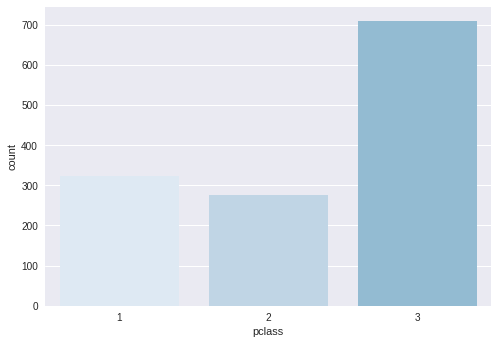

In [16]:
seaborn.countplot(x="pclass", data=titanic)

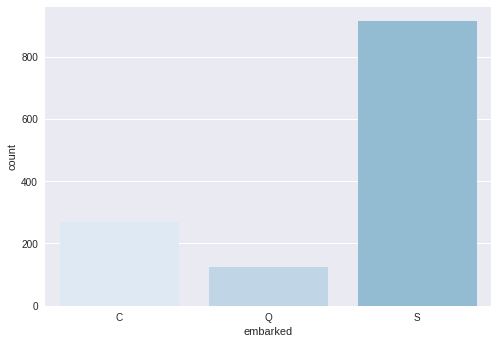

In [17]:
seaborn.countplot(x="embarked", data=titanic)

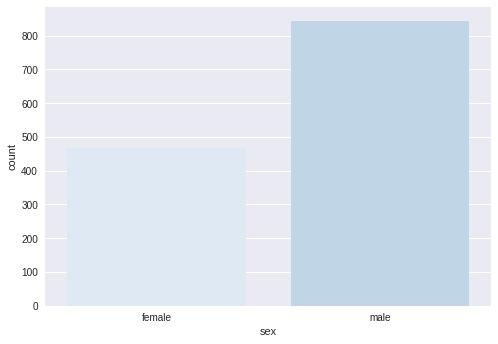

In [18]:
seaborn.countplot(x="sex", data=titanic)

Out of range values are discarded because they are non-relevant.

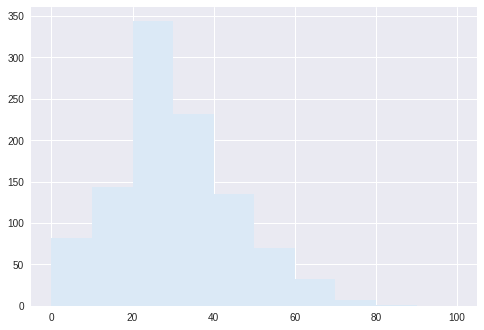

In [19]:
titanic.age.hist(range=(0,100), bins=10)

### Question 3

We collect the first letter of the cabin number to get the cabin's desk, in order to do that, we discard missing values.

We assumed that all the desks were labeled by a letter between A and G, we discarded desk labeled T since he doesn't exist.

We could not determine which desk to choose when the cabin was labeled "F E45”, thus we decided to only keep the first letter in order to simplify the calculation.

If a passenger has multiple cabin on different desks, we choose the first one.

G     5
F    21
A    22
E    41
D    46
B    65
C    94
Name: cabin, dtype: int64

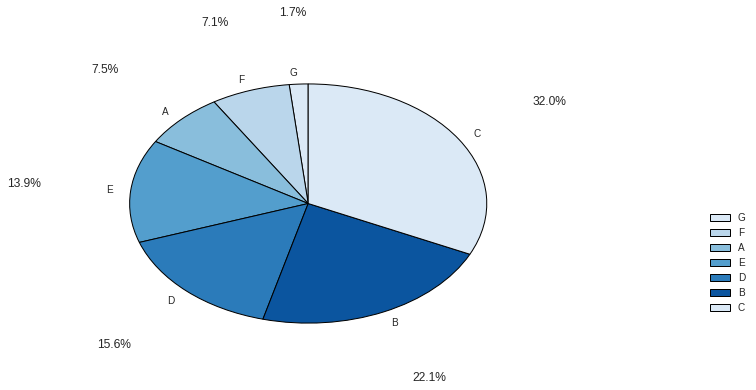

In [20]:
def pie_chart(data, labels):
    pie = matplotlib.pyplot.pie(data, labels=labels, autopct='%1.1f%%', pctdistance=1.6, startangle=90, wedgeprops = {'linewidth':1, 'edgecolor':'black'})
    matplotlib.pyplot.legend(pie[0], labels, loc="upper right", bbox_to_anchor=(1.5, 0.5))


cabin = titanic.cabin.dropna().str[0]
cabin = cabin[cabin.between('A','G')]
cabin = cabin.groupby(lambda x: cabin[x]).count().sort_values()

pie_chart(cabin, cabin.index.values)
cabin

### Question 4

##### First class

0    123
1    200
Name: survived, dtype: int64

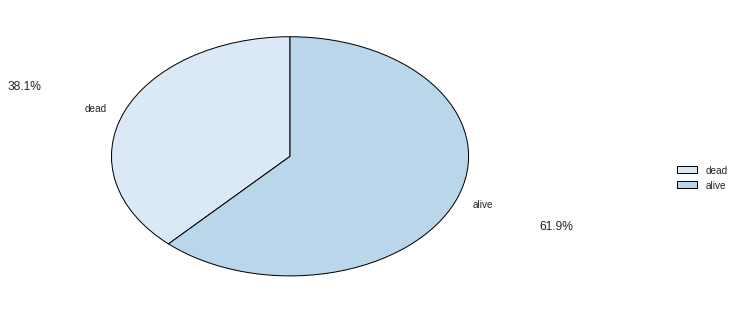

In [21]:
survived = titanic[titanic.pclass == 1].survived
survived = survived.groupby(lambda x: survived[x]).count()

pie_chart(survived, ['dead','alive'])
survived

In [ ]:
##### Second class


0    158
1    119
Name: survived, dtype: int64

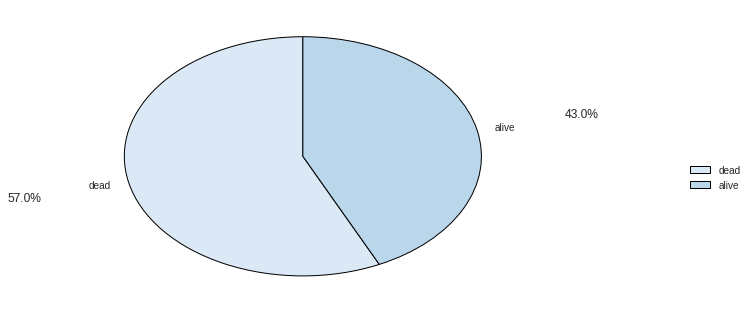

In [22]:
survived = titanic[titanic.pclass == 2].survived
survived = survived.groupby(lambda x: survived[x]).count()

pie_chart(survived, ['dead','alive'])
survived

##### Third class

0    528
1    181
Name: survived, dtype: int64

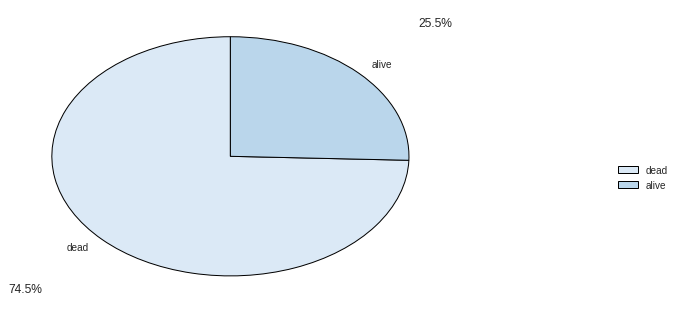

In [23]:
survived = titanic[titanic.pclass == 3].survived
survived = survived.groupby(lambda x: survived[x]).count()

pie_chart(survived, ['dead','alive'])
survived

### Question 5

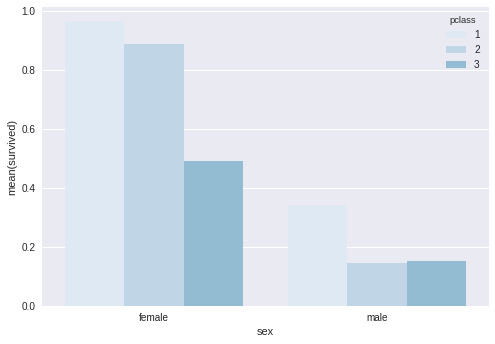

In [24]:
seaborn.barplot(x="sex", y="survived", hue="pclass", ci=None, data=titanic)

### Question 6

We have chosen to remove all the rows where the age is unknown, as it would not have so much meaning when we use age categories
We also decide to use the qcut function over an exact splitting of the rows, because we thing it is more meaningful to sort rows based on the median age than to just cut randomly. To be more precise, when sorting and splitting, people who were 28 years old were randomly sorted in a category or another. Here we prefer to sort all 28 years old in the younger category but at the cost of not having 2 exactly equal categories


In [6]:
toSort= pd.read_excel(DATA_FOLDER + '/titanic.xls')
toSort.dropna(axis=0,subset=['age'],inplace=True)
toSort.dropna(axis=0,subset=['survived'],inplace=True)
fP = pd.qcut(toSort.age,2,labels=False)
#qcut gives us 0 and 1 for each row be convert it to boolean and then separate rows associated to True and associated to false
fP = [bool(x) for x in fP]
res={}
#Using only two indexes might be overkill but it allows us to scale if needed (4 categories for example)
res[0] = toSort[fP]
res[1] = toSort[np.logical_not(fP)]
fr=[]
#We deal with each category separately
for i in range(2):
    #We group by class and sex and get the sum for each one
    tem =res[i].groupby(['pclass', 'sex']).agg({'survived': 'sum'})
    #We prefer to have a percentage
    tem = tem.groupby(level=0).apply(lambda x:100 * x / float(x.sum()))
    fr.append(tem)
#We concatenate and beautify a bit the result
re = pd.concat(fr,axis=1,keys=['young','old'])
re.columns = re.columns.droplevel(level = 1)
re['young'] = re['young'].astype(str) + '%'
re['old'] = re['old'].astype(str) + '%'
re.rename(columns = {'young':'% of young survivors'},inplace=True)
re.rename(columns = {'old':'% of old survivors'},inplace=True)
re

ModuleNotFoundError: No module named 'xlrd'